# EA ALMA Data Analysis Workshop
我抄我 好爽 
ratio code 好用一直用    
加的 Multi-band，有個韓國老哥直接帶飛我倆

## Data Reduction

就是 tclean 那之類的東西，之後有閒我再推一個

## Code prepareeeee 

In [2]:
# modularrr
from casatasks import importfits, imsmooth, imregrid, exportfits, imsubimage
import shutil
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u 
commonPath = '/Users/aqing/Documents/1004/proddduct/'

measures_update ... acquiring the lock ... 
  ... finding available measures at www.astron.nl ...
  ... downloading WSRT_Measures_20250924-160001.ztar from ASTRON server to /Users/aqing/.casa/data ...
  ... measures data updated at /Users/aqing/.casa/data


In [13]:
# hand made functionnnnnnns

# 存檔芝士
def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam): 
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 針對這次 WS 開發的一款綜合型工具
'''
方便的用 imsmooth() 處理 FITS 的函式
建議以變數傳入 pathIN, tarBeam, fitsOUT

parameters:
pathIN  (str)  : 原來那cube 的檔案位置
kernel  (str)  : 我是都卷 Gausssian kernel 啦
tarBeam (Beam) : 目標波束，格式如範例
csrf           : imregrid() 用 template=get 得到的一個東西
fitsOUT (str)  : 輸出檔案的名字，雖然很意外但不可以包含括號, ".fits" is not included
casaOUT (str)  : not include ".image"
'''
def Align_ima(pathIN, kernel, tarBeam, csrf, fitsOUT, casaOUT) : # 因為又統一解析度又重新投影，所以命名為對其
    importfits(fitsimage=pathIN, imagename='casaIN.image', overwrite=True) 
    print('itadakimasu!')

    imsmooth(imagename='casaIN.image', outfile=f'{casaOUT}.image', kernel=kernel, beam=tarBeam, targetres=True, overwrite=True)
    exportfits(imagename=f'{casaOUT}.image', fitsimage=f'{fitsOUT}.fits', overwrite=True) # export smoothed data

    imregrid(imagename=f'{casaOUT}.image', output=f'{casaOUT}_regrid.image', template=csrf, axes=[0, 1], overwrite=True)
    exportfits(imagename=f'{casaOUT}_regrid.image', fitsimage=f'{fitsOUT}_regrid.fits', overwrite=True) # export smoothed && regridded data

    shutil.rmtree('casaIN.image')
    print('Metafiles are cleaned.')
    print()

## Smooth, Regrid and Align

In [ ]:
# 流水線
tarBeam = {'major': '0.521arcsec', 'minor': '0.521arcsec', 'pa': '0deg'}
bandList = [3, 6, 7] # 超可悲
csrf = imregrid(imagename='band3.im', template="get") # imgrid
for n in bandList:
    path = f'{commonPath}band{n}.fits'
    fout = f'band{n}_smoothed'
    cout = f'band{n}_smoothed'
    #Align_ima(path, 'g', tarBeam, csrf, fout, cout) ###先註解掉

### align
我不知道這還有這個用途欸  
參數是灰色姊姊調的，我是瓠瓜。

In [14]:
# Align
for n in bandList:
    imsubimage(imagename=f'band{n}_smoothed_regrid.image',
               outfile=f'band{n}_smoothed_regrid_align.image',
               region = 'circle[[16h58m17.216, -42d52m7.4s], 10arcsec]', overwrite=True)
    exportfits(imagename=f'band{n}_smoothed_regrid_align.image',
               fitsimage=f'band{n}_smoothed_regrid_align.fits', overwrite=True) #  檔名後綴直接變得巨長

## Spectral index
flux = A*f^(alpha)  
alpha 就是 spectral index

### Flux ratio

In [7]:
# import data

# {bandName:{裝資料的小字典}}
dataa = {}
for n in bandList:
    bandName = f'band{n}'
    hdul = fits.open(f"{commonPath}{bandName}_smoothed_regrid_align.fits")

    header = hdul[0].header
    image = hdul[0].data.squeeze()
    wcs = WCS(header, naxis=2)

    # 存入資料字典，這樣是雙層字典，方便以鍵取值
    dataa[bandName] = {
        "hdul": hdul,
        "header": header,
        "ima": image,
        "wcs": wcs,
    }

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
# Ratioooo

# 點菜(分子, 分母, refFREQ fraction)
requiree = [('band3', 'band6', 0.4648),   
            ('band6', 'band7', 0.6960),  
            ]

ratio_map = {} # 字典上癮了是吧
for nu, de, _ in requiree:
        numer, denom = dataa[nu]['ima'], dataa[de]['ima']
        ratio = np.where(denom>0, numer/denom, np.nan)
        ratio = np.where(ratio>40, np.nan, ratio) # 撇掉一些浮沫
        ratio = np.where(ratio<-40, np.nan, ratio)
        #ratio = np.where(ratio<0, np.nan, ratio)
        ratio_map[f'{nu}_over_{de}'] = ratio

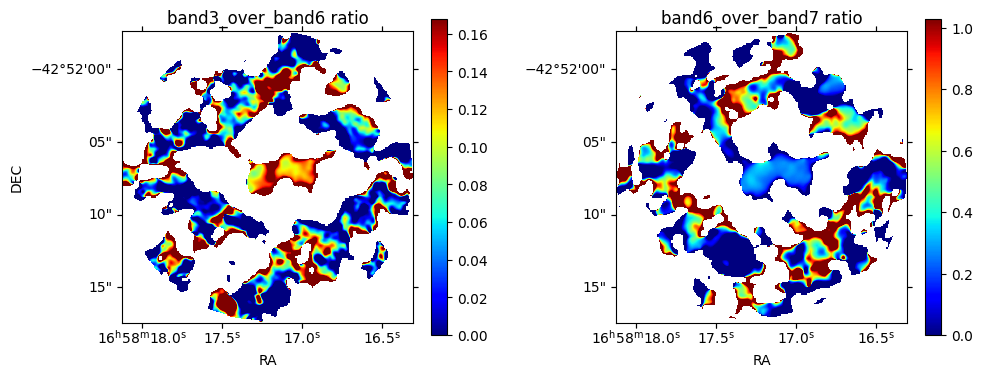

In [17]:
# show the ratio ima

# 反正只是預覽
refwcs = dataa['band3']['wcs']

fig_ro, ax = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': refwcs})
ax_flat = ax.flatten()

for i, k in enumerate(ratio_map): 
    ima_here = ratio_map[k]
    obj = ax_flat[i].imshow(ima_here, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ima_here, 80))
    fig_ro.colorbar(obj, ax=ax_flat[i])

    ax_flat[i].set_title(f"{k} ratio")
    ax_flat[i].set_xlabel('RA')

    if i == 0:
        ax_flat[i].set_ylabel('DEC')
    else:
        ax_flat[i].set_ylabel(' ')
    
plt.tight_layout()
plt.show()

In [10]:
# save the ratio ima as FITS
refheader = dataa['band3']['header']
for k in ratio_map:
    Save_as_FITS(f'Ratio_{k}', ratio_map[k], refheader, refheader, False)

Successfully saved a new FITS file as Ratio_band3_over_band6.fits
Successfully saved a new FITS file as Ratio_band6_over_band7.fits


### Spectral index 本人

In [11]:
spec_index = {}
for nu, de, reff in requiree:
        numer, denom = dataa[nu]['ima'], dataa[de]['ima']
        ratio = np.where(denom>0, numer/denom, np.nan)
        ratio = np.where(ratio>40, np.nan, ratio) # 撇掉一些浮沫
        ratio = np.where(ratio<-40, np.nan, ratio)
        ratio = np.log(ratio) # 以e為底
        specInx = ratio / np.log(reff)
        spec_index[f'{nu}_over_{de}'] = specInx


/var/folders/tp/j3nk035n1js_rwj31_4mv8vr0000gn/T/ipykernel_9413/66529417.py:7: RuntimeWarning: invalid value encountered in log
  ratio = np.log(ratio) # 以e為底


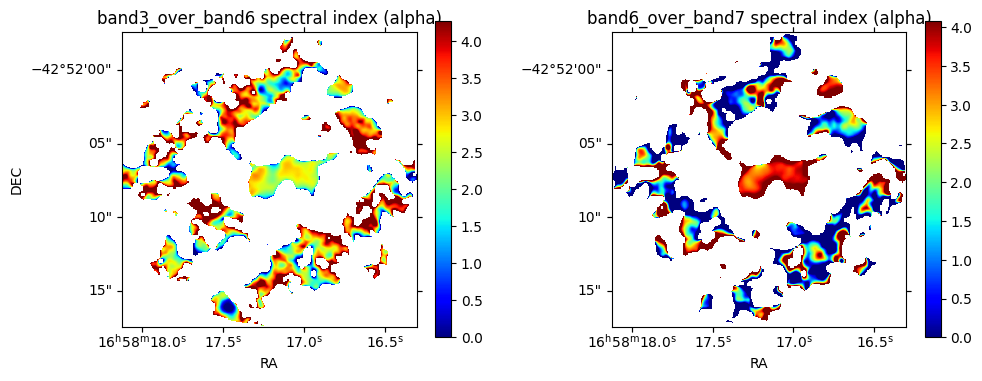

In [18]:
# show the spectral index distrubution
fig_ro, ax = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': refwcs})
ax_flat = ax.flatten()

for i, k in enumerate(spec_index): 
    ima_here = spec_index[k]
    obj = ax_flat[i].imshow(ima_here, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ima_here, 80))
    fig_ro.colorbar(obj, ax=ax_flat[i])

    ax_flat[i].set_title(f"{k} spectral index (alpha)")
    ax_flat[i].set_xlabel('RA')

    if i == 0:
        ax_flat[i].set_ylabel('DEC')
    else:
        ax_flat[i].set_ylabel(' ')
    
plt.tight_layout()
plt.show()

In [25]:
# save the ratio ima as FITS
refheader = dataa['band3']['header']
for k in spec_index:
    Save_as_FITS(f'specInx_{k}', spec_index[k], refheader, refheader, False)

Successfully saved a new FITS file as specInx_band3_over_band6.fits
Successfully saved a new FITS file as specInx_band6_over_band7.fits


[0.0001072, 0.001072, 0.002144, 0.003216, 0.00536, 0.009648, 0.013936, 0.018224, 0.022512]


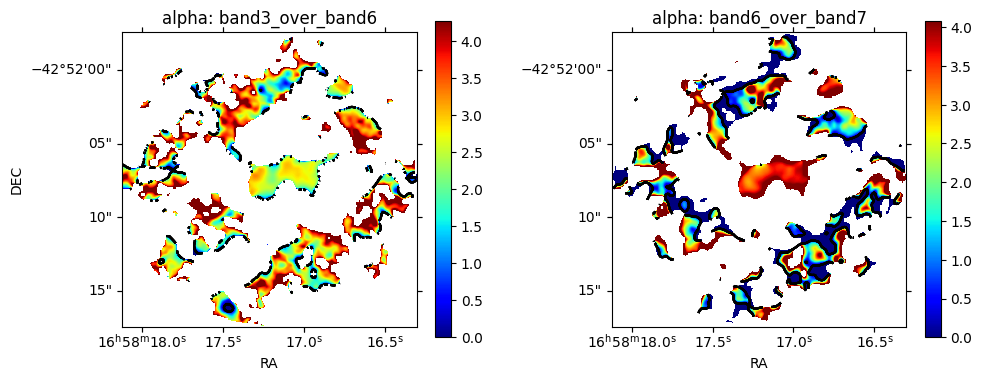

In [24]:
# 韓國老哥畫一個圖巨好看
# 結果他媽的我畫不出來啦
fig_ro, ax = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': refwcs})
ax_flat = ax.flatten()

# contour levels
contourStep = 1.072E-3
contour_steps_n = [0.1, 1, 2, 3, 5, 9, 13, 17, 21]
contour_level = []
for i in contour_steps_n:
    contour_level.append(i*contourStep)

print(contour_level)

for i, k in enumerate(spec_index): 
    ima_here = spec_index[k]
    obj = ax_flat[i].imshow(ima_here, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ima_here, 80))
    fig_ro.colorbar(obj, ax=ax_flat[i])
    ax_flat[i].contour(ima_here, contour_level,colors='black') # 新東西

    ax_flat[i].set_title(f"alpha: {k}")
    ax_flat[i].set_xlabel('RA')

    if i == 0:
        ax_flat[i].set_ylabel('DEC')
    else:
        ax_flat[i].set_ylabel(' ')
    
plt.tight_layout()
plt.show()